In [1]:
pip install transformers


[notice] A new release of pip available: 22.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

# from transformers import TrainingArguments, Trainer

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


In [3]:
from sklearn.preprocessing import StandardScaler
import numpy as np

fold_pamap = "../down_stream_dataset/realworld_dataset/"
train_xyz = np.load(f"{fold_pamap}x_train.npy")
valid_xyz = np.load(f"{fold_pamap}x_valid.npy")
test_xyz = np.load(f"{fold_pamap}x_test.npy")
train_label = np.load(f"{fold_pamap}y_train.npy")
valid_label = np.load(f"{fold_pamap}y_valid.npy")
test_label = np.load(f"{fold_pamap}y_test.npy")

# データの形を確認
print(f"Train data shape: {train_xyz.shape}, Train label shape: {train_label.shape}")
print(f"Valid data shape: {valid_xyz.shape}, Valid label shape: {valid_label.shape}")
print(f"Test data shape: {test_xyz.shape}, Test label shape: {test_label.shape}")

# 各データセットを個別に標準化
scaler_train = StandardScaler()
scaler_valid = StandardScaler()
scaler_test = StandardScaler()

# train_xyz の標準化
train_xyz_reshaped = train_xyz.reshape(-1, train_xyz.shape[-1])  # 2Dに変換
scaled_train_xyz = scaler_train.fit_transform(train_xyz_reshaped)  # 標準化
scaled_train_xyz = scaled_train_xyz.reshape(train_xyz.shape)  # 元の形に戻す

# valid_xyz の標準化
valid_xyz_reshaped = valid_xyz.reshape(-1, valid_xyz.shape[-1])  # 2Dに変換
scaled_valid_xyz = scaler_valid.fit_transform(valid_xyz_reshaped)  # 標準化
scaled_valid_xyz = scaled_valid_xyz.reshape(valid_xyz.shape)  # 元の形に戻す

# test_xyz の標準化
test_xyz_reshaped = test_xyz.reshape(-1, test_xyz.shape[-1])  # 2Dに変換
scaled_test_xyz = scaler_test.fit_transform(test_xyz_reshaped)  # 標準化
scaled_test_xyz = scaled_test_xyz.reshape(test_xyz.shape)  # 元の形に戻す

# 各データセットの形状を再確認
print(f"Scaled Train data shape: {scaled_train_xyz.shape}")
print(f"Scaled Valid data shape: {scaled_valid_xyz.shape}")
print(f"Scaled Test data shape: {scaled_test_xyz.shape}")


Train data shape: (7964, 3, 300), Train label shape: (7964,)
Valid data shape: (1992, 3, 300), Valid label shape: (1992,)
Test data shape: (2490, 3, 300), Test label shape: (2490,)
Scaled Train data shape: (7964, 3, 300)
Scaled Valid data shape: (1992, 3, 300)
Scaled Test data shape: (2490, 3, 300)


In [4]:
print(pd.Series(train_label).value_counts())
print(pd.Series(test_label).value_counts())
print(pd.Series(valid_label).value_counts())


4    1297
3    1139
5    1126
1    1119
6    1115
7    1102
0     900
2     166
dtype: int64
4    390
7    379
3    357
6    351
1    351
5    348
0    268
2     46
dtype: int64
4    315
7    308
5    299
6    283
3    278
1    261
0    208
2     40
dtype: int64


In [5]:
train_xyz = scaled_train_xyz
valid_xyz = scaled_valid_xyz
test_xyz = scaled_test_xyz

In [6]:
train_xyz = np.transpose(train_xyz, (0, 2, 1))
valid_xyz = np.transpose(valid_xyz, (0, 2, 1))
test_xyz = np.transpose(test_xyz, (0, 2, 1))

In [7]:
print(train_xyz.shape)

(7964, 300, 3)


In [8]:
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification, BertConfig

# カスタムBERTモデル
class BertForAccelerometerClassification(BertForSequenceClassification):
    def __init__(self, config, input_dim=3):
        super().__init__(config)
        self.acc_embedding = torch.nn.Linear(input_dim, config.hidden_size)

    def forward(self, input_embeds=None, labels=None, **kwargs):
        # 加速度データをエンベディング層で変換
        if input_embeds is not None:
            input_embeds = self.acc_embedding(input_embeds)  # (batch_size, seq_len, hidden_size)

        # BERT本体を通過
        outputs = self.bert(inputs_embeds=input_embeds, **kwargs)

        # 分類ヘッドを通過
        logits = self.classifier(outputs.pooler_output)

        # 損失を計算
        loss = None
        if labels is not None:
            loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return {"loss": loss, "logits": logits}


In [9]:
# データセットの準備
class SensorDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            "input_embeds": torch.tensor(self.data[idx], dtype=torch.float32),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }
# データセットとデータローダの作成
train_dataset = SensorDataset(train_xyz, train_label)
eval_dataset = SensorDataset(valid_xyz, valid_label)
test_dataset = SensorDataset(test_xyz, test_label)

In [10]:
num_classes = len(np.unique(train_label))

In [11]:
# モデル設定
from transformers import TrainingArguments, Trainer
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=num_classes)
model = BertForAccelerometerClassification.from_pretrained("bert-base-uncased", config=config)

# トレーニング設定
training_args = TrainingArguments(
    output_dir="./results_realworld",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=16,
    save_steps=0,
    save_total_limit=None,
    #logging_dir = "./logs_distilBERT",
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=10,
    max_grad_norm=1.0, # 勾配クリッピング
    fp16=True, # fp16計算
    #weight_decay=0.01
)

# カスタムTrainerクラス
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # モデルに渡す入力をフィルタリング
        inputs = {k: v for k, v in inputs.items() if k in ["input_embeds", "labels"]}
        return super().compute_loss(model, inputs, return_outputs=return_outputs)

# Trainerの作成
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# トレーニング実行
trainer.train()

Some weights of BertForAccelerometerClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['acc_embedding.bias', 'acc_embedding.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
200,1.334600,1.081273
400,0.946400,0.929856
600,0.822700,0.898147
800,0.694000,0.834005
1000,0.708600,0.788327
1200,0.625400,0.636442
1400,0.556100,0.625650
1600,0.673900,0.655331
1800,0.550400,0.644458
2000,0.532800,0.636109


TrainOutput(global_step=4980, training_loss=0.5696722368399302, metrics={'train_runtime': 1471.8662, 'train_samples_per_second': 54.108, 'train_steps_per_second': 3.383, 'total_flos': 0.0, 'train_loss': 0.5696722368399302, 'epoch': 10.0})

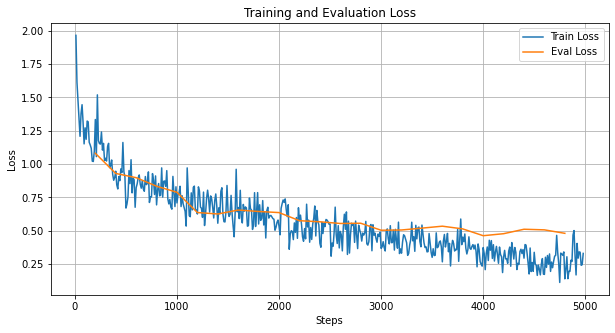

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       268
           1       0.77      0.83      0.80       351
           2       0.98      1.00      0.99        46
           3       0.90      0.90      0.90       357
           4       0.96      0.89      0.92       390
           5       0.81      0.90      0.85       348
           6       0.84      0.85      0.85       351
           7       0.95      0.82      0.88       379

    accuracy                           0.87      2490
   macro avg       0.89      0.89      0.89      2490
weighted avg       0.88      0.87      0.87      2490



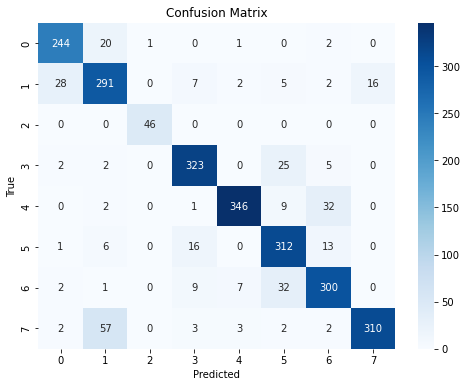

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ロスの履歴を取得
train_loss = []
train_steps = []
eval_loss = []
eval_steps = []

# トレーニング中のログから損失を抽出
for log in trainer.state.log_history:
    if "loss" in log.keys():
        train_loss.append(log["loss"])
        train_steps.append(log["step"])
    if "eval_loss" in log.keys():
        eval_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])

# ロスのプロット
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label='Train Loss', color='C0')
plt.plot(eval_steps, eval_loss, label='Eval Loss', color='C1')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Evaluation Loss')
plt.grid(True)
plt.show()

# モデルで予測
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# 分類レポートの生成
report = classification_report(test_label, preds, target_names=[str(i) for i in range(0, num_classes)])
print(report)

# 混同行列の計算とプロット
cm = confusion_matrix(test_label, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(0, num_classes)], yticklabels=[str(i) for i in range(0, num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
